In [26]:
from prophet import Prophet
import pandas as pd

In [27]:
from sklearn.metrics import mean_absolute_percentage_error

In [28]:
import sys
sys.path.insert(0, '/home/tegbe/2023/ccl/timeRobert/')  # Replace 'path/to/parent_directory' with the absolute path to the parent directory

from eda import exp

In [29]:
df = exp.import_data()
df_pdoil = df[['DATE', 'PD_Oil Rate (stb/day)']]
df_pdoil.head(5)

,DATE,PD_Oil Rate (stb/day)
0,1977-04-01,474.600000
1,1977-05-01,524.761905
2,1977-06-01,1096.793103
3,1977-07-01,2372.233010
4,1977-08-01,3357.987013


In [31]:
# Rename columns to meet prophet model template
df_pdoil = df_pdoil.rename(columns={'DATE': 'ds', 'PD_Oil Rate (stb/day)': "y"})
df_pdoil.head(5)

,ds,y
0,1977-04-01,474.600000
1,1977-05-01,524.761905
2,1977-06-01,1096.793103
3,1977-07-01,2372.233010
4,1977-08-01,3357.987013


In [32]:
df_pdoil_clean = df_pdoil.dropna(axis=0)

In [33]:
df_pdoil.shape, df_pdoil_clean.shape

((333, 2), (257, 2))

In [34]:
df_pdoil_clean

,ds,y
0,1977-04-01,474.600000
1,1977-05-01,524.761905
2,1977-06-01,1096.793103
3,1977-07-01,2372.233010
4,1977-08-01,3357.987013
...,...,...
253,1999-07-01,887.447331
254,1999-08-01,798.138065
255,1999-09-01,777.535333
256,1999-10-01,774.953818


In [35]:
# Split data frame to train and test
X_train, y_train, X_test, y_test = exp.train_test_split_by_date(df_pdoil_clean, 'ds', 'y', '1999-01-01')

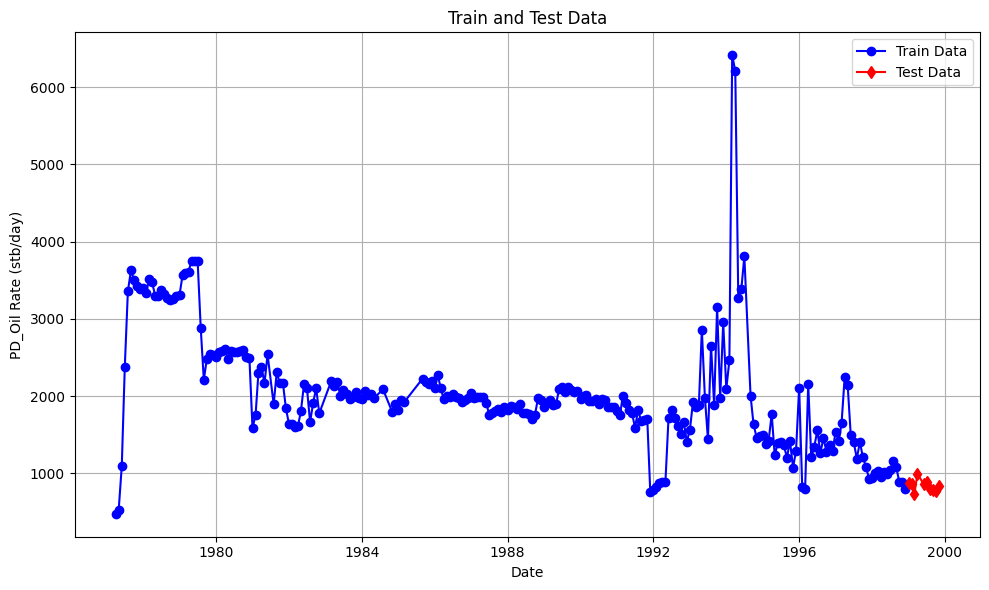

In [36]:
import matplotlib.pyplot as plt

# Assuming X_train, y_train, X_test, y_test are obtained from train_test_split_by_date function

# Plotting train data
plt.figure(figsize=(10, 6))

# Scatter plot for train data
plt.plot(X_train['ds'], y_train, color='blue', label='Train Data', marker='o')

# Scatter plot for test data
plt.plot(X_test['ds'], y_test, color='red', label='Test Data', marker='d')

plt.title('Train and Test Data')
plt.xlabel('Date')
plt.ylabel('PD_Oil Rate (stb/day)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [37]:
df_train = pd.concat([X_train, y_train], axis=1)
df_test =pd.concat([X_test, y_test], axis=1)

In [12]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10 entries, 247 to 257
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   ds      10 non-null     datetime64[ns]
 1   y       10 non-null     float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 240.0 bytes


In [38]:
df_test.isnull().sum()

ds    0
y     0
dtype: int64

## Fit and train model

In [95]:
# def mean_absolute_percentage_error(y_true, y_pred): 
#     y_true, y_pred = np.array(y_true), np.array(y_pred)
#     return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [64]:
import matplotlib.pyplot as plt

def plot_train_infer(X_train, y_train, forecast_ds):
    plt.figure(figsize=(15, 5))

    # Plot original training data
    plt.plot(X_train['ds'], y_train['y'], color='blue', label='Actual', marker='o')

    # Plot forecasted data
    plt.plot(forecast_ds['ds'], forecast_ds['yhat'], color='red', label='Prophet Model Fitting', marker='d')

    plt.title('Actual vs Predicted Values')
    plt.xlabel('Date')
    plt.ylabel('PD_Oil Rate (stb/day)')
    plt.legend()
    # plt.grid(True)
    # plt.tight_layout()
    plt.show()

### Prophet model

In [49]:
model = Prophet(
    seasonality_mode='multiplicative',
    seasonality_prior_scale=10.0,
    changepoint_prior_scale=0.1,#0.05
    holidays_prior_scale=15.0,
    changepoint_range=0.8
)
model.fit(df_train)

13:50:00 - cmdstanpy - INFO - Chain [1] start processing
13:50:00 - cmdstanpy - INFO - Chain [1] done processing


In [57]:
#future = model.make_future_dataframe(periods=365)
forecast_entire_data = model.predict(df_train)
forecast_entire_data[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
242,1998-08-01,1171.578207,351.024994,1996.036266
243,1998-09-01,1152.266973,374.641647,1955.555318
244,1998-10-01,1163.319113,327.007050,1985.818152
245,1998-11-01,1106.761882,355.759738,1945.390420
246,1998-12-01,1093.502177,283.346492,1883.880991


In [58]:

import numpy as np
from sklearn.metrics import mean_absolute_percentage_error, mean_absolute_error, mean_squared_error, r2_score

prophet_forecast = forecast_entire_data['yhat']
prophet_mape = mean_absolute_percentage_error(y_train, prophet_forecast)
prophet_mae = mean_absolute_error(y_train, prophet_forecast)
prophet_mse = mean_squared_error(y_train, prophet_forecast)
prophet_rmse = np.sqrt(prophet_mse)
prophet_r2 = r2_score(y_train, prophet_forecast)

print("XGBoost MAPE:", prophet_mape)
print("XGBoost MAE:", prophet_mae)
print("XGBoost MSE:", prophet_mse)
print("XGBoost RMSE:", prophet_rmse)
print("XGBoost R2:", prophet_r2)

XGBoost MAPE: 0.21426138122938318
XGBoost MAE: 347.56776005054024
XGBoost MSE: 396442.6787786403
XGBoost RMSE: 629.6369420377431
XGBoost R2: 0.35796039422803394


In [51]:
X_train.shape, y_train.shape, forecast_entire_data[['ds']].shape, forecast_entire_data[['yhat']].shape

((247, 1), (247,), (612, 1), (612, 1))

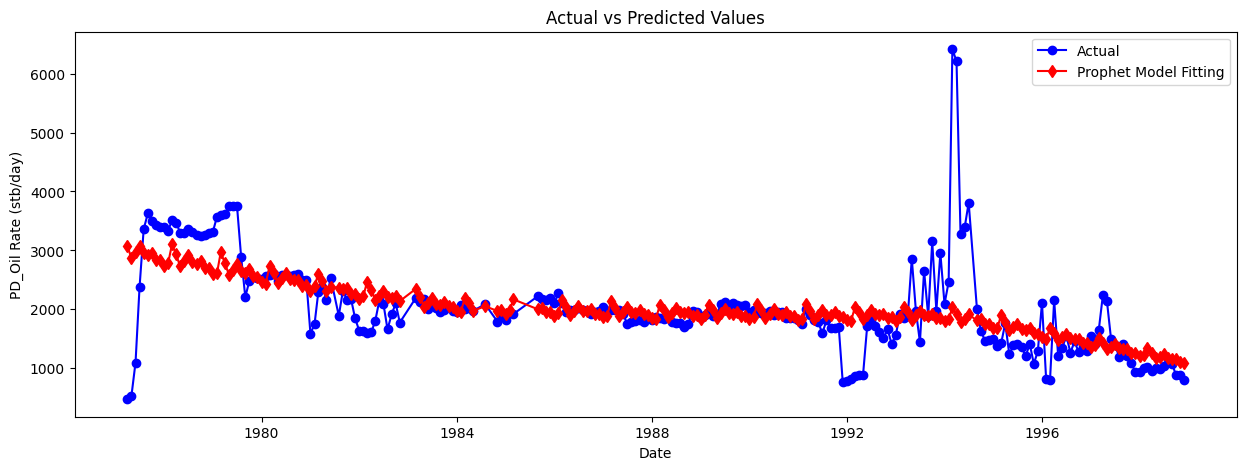

In [65]:
plot_train_infer(df_train, df_train, forecast_entire_data)

In [53]:
forecast_test = model.predict(X_test)
forecast_test[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

X_train.shape, y_train.shape, forecast_test[['ds']].shape, forecast_test[['yhat']].shape

((247, 1), (247,), (10, 1), (10, 1))

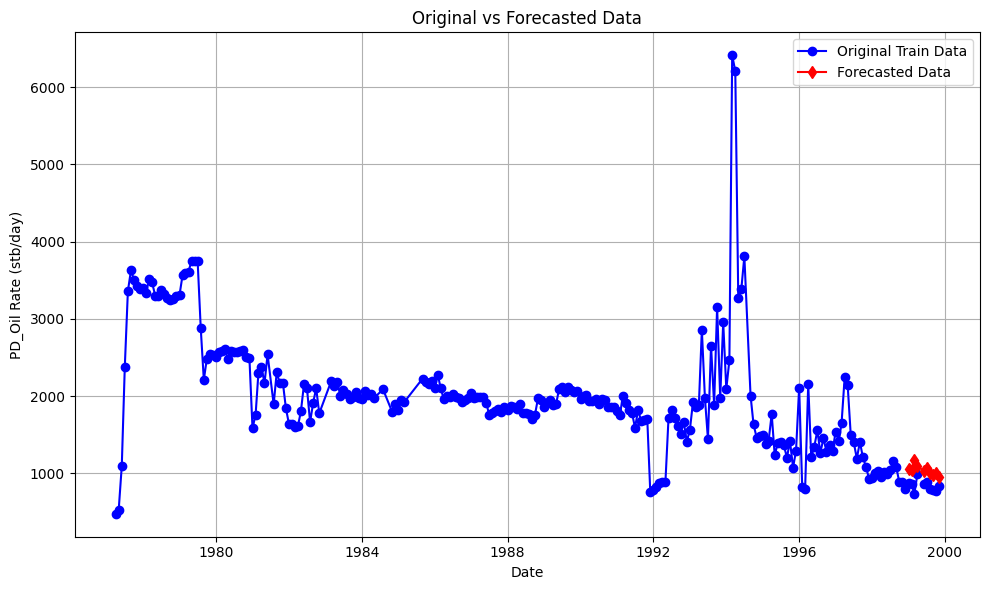

In [54]:
plot_train_infer(df_pdoil, df_pdoil, forecast_test)

In [104]:
X_test

,ds
247,1999-01-01
248,1999-02-01
249,1999-03-01
250,1999-04-01
252,1999-06-01
253,1999-07-01
254,1999-08-01
255,1999-09-01
256,1999-10-01
257,1999-11-01


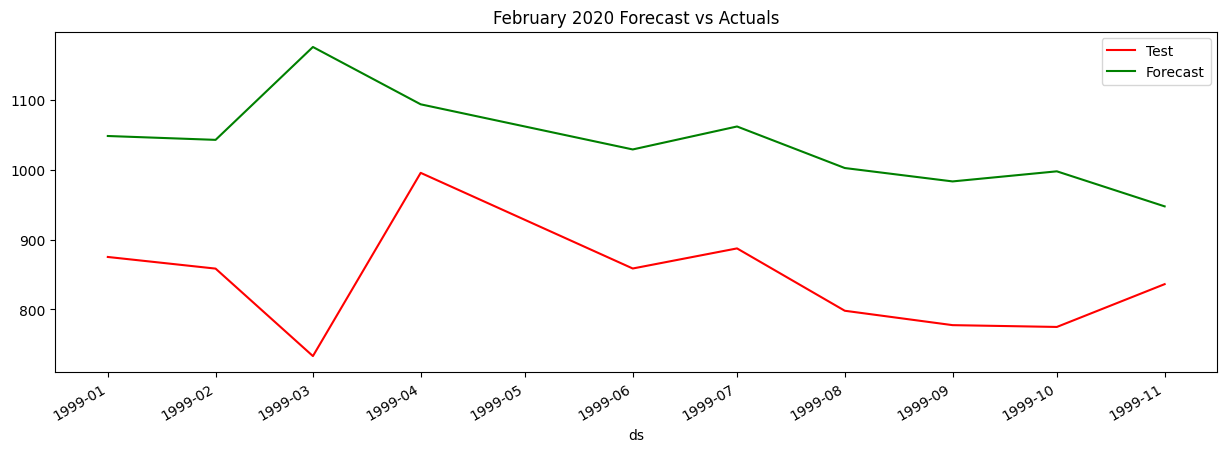

In [105]:
f, ax = plt.subplots(figsize=(14,5))
f.set_figheight(5)
f.set_figwidth(15)
df_test.plot(kind='line',x='ds', y='y', color='red', label='Test', ax=ax)
forecast_test.plot(kind='line',x='ds',y='yhat', color='green',label='Forecast', ax=ax)
plt.title('February 2020 Forecast vs Actuals')
plt.show()

In [55]:
# mape = mean_absolute_percentage_error(y_test, forecast_test['yhat'])
# print("MAPE",round(mape,4))
import numpy as np
from sklearn.metrics import mean_absolute_percentage_error, mean_absolute_error, mean_squared_error, r2_score

profet_forecast = forecast_test['yhat']
profet_mape = mean_absolute_percentage_error(y_test, profet_forecast)
profet_mae = mean_absolute_error(y_test, profet_forecast)
profet_mse = mean_squared_error(y_test, profet_forecast)
profet_rmse = np.sqrt(profet_mse)
profet_r2 = r2_score(y_test, profet_forecast)

print("XGBoost MAPE:", profet_mape)
print("XGBoost MAE:", profet_mae)
print("XGBoost MSE:", profet_mse)
print("XGBoost RMSE:", profet_rmse)
print("XGBoost R2:", profet_r2)

XGBoost MAPE: 0.2452259027768287
XGBoost MAE: 198.8285343218119
XGBoost MSE: 47549.25348645094
XGBoost RMSE: 218.05791314797762
XGBoost R2: -8.565013257347173


#### parameter search

In [107]:
from sklearn.model_selection import ParameterGrid
params_grid = {'seasonality_mode':('multiplicative','additive'),
               'seasonality_prior_scale':[0.4,0.5,0.6,0.7,0.8], 
               'changepoint_prior_scale':[0.4,0.5,0.6,0.7,0.8],
              'holidays_prior_scale':[0.4,0.5,0.6,0.7,0.8],
              'changepoint_range':[0.4,0.5,0.6,0.7,0.8],
              'n_changepoints' : [300,500,600]}
grid = ParameterGrid(params_grid)
cnt = 0
for p in grid:
    cnt = cnt+1

print('Total Possible Models',cnt)

Total Possible Models 3750


In [108]:
import random
import numpy as np

model_parameters = pd.DataFrame(columns=['MAPE', 'Parameters'])  # Ensure it's explicitly a DataFrame

# Your loop
for p in grid:
    test = pd.DataFrame()
    #print(p)
    random.seed(0)
    hyper_model = Prophet(
        changepoint_prior_scale=p['changepoint_prior_scale'],
        holidays_prior_scale=p['holidays_prior_scale'],
        n_changepoints=p['n_changepoints'],
        seasonality_mode=p['seasonality_mode'],
        weekly_seasonality=True,
        daily_seasonality=True,
        yearly_seasonality=True,
        interval_width=0.95
    )
    hyper_model.fit(df_train)
    train_forecast = hyper_model.predict(X_train)
    test = train_forecast[['ds', 'yhat']]
    
    MAPE = mean_absolute_percentage_error(y_train, abs(test['yhat']))
    #print('Mean Absolute Percentage Error(MAPE)------------------------------------', MAPE)
    
    # Concatenate the DataFrame along rows (ignore_index=True to reset index)
    model_parameters = pd.concat([model_parameters, pd.DataFrame({'MAPE': [MAPE], 'Parameters': [p]})], ignore_index=True)

09:52:37 - cmdstanpy - INFO - Chain [1] start processing


09:52:38 - cmdstanpy - INFO - Chain [1] done processing
/tmp/ipykernel_47415/2431186048.py:29: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  model_parameters = pd.concat([model_parameters, pd.DataFrame({'MAPE': [MAPE], 'Parameters': [p]})], ignore_index=True)
09:52:39 - cmdstanpy - INFO - Chain [1] start processing
09:52:40 - cmdstanpy - INFO - Chain [1] done processing
09:52:40 - cmdstanpy - INFO - Chain [1] start processing
09:52:41 - cmdstanpy - INFO - Chain [1] done processing
09:52:41 - cmdstanpy - INFO - Chain [1] start processing
09:52:43 - cmdstanpy - INFO - Chain [1] done processing
09:52:43 - cmdstanpy - INFO - Chain [1] start processing
09:52:44 - cmdstanpy - INFO - Chain [1] done processing
09:52:44 - cmdstanpy - INFO - Chain [1

KeyboardInterrupt: 

In [109]:
parameters = model_parameters.sort_values(by=['MAPE'])
parameters = parameters.reset_index(drop=True)
parameters.head()

,MAPE,Parameters
0,0.104667,"{'changepoint_prior_scale': 0.4, 'changepoint_..."
1,0.104667,"{'changepoint_prior_scale': 0.4, 'changepoint_..."
2,0.104667,"{'changepoint_prior_scale': 0.4, 'changepoint_..."
3,0.104667,"{'changepoint_prior_scale': 0.4, 'changepoint_..."
4,0.104667,"{'changepoint_prior_scale': 0.4, 'changepoint_..."


In [110]:
parameters['Parameters'].iloc[0]

{'changepoint_prior_scale': 0.4,
 'changepoint_range': 0.4,
 'holidays_prior_scale': 0.4,
 'n_changepoints': 300,
 'seasonality_mode': 'multiplicative',
 'seasonality_prior_scale': 0.4}

In [ ]:
parameters = model_parameters.sort_values(by=['MAPE'])
parameters = parameters.reset_index(drop=True)
parameters.head()

,MAPE,Parameters
0,10.466687,"{'changepoint_prior_scale': 0.4, 'changepoint_..."
1,10.466687,"{'changepoint_prior_scale': 0.4, 'changepoint_..."
2,10.466687,"{'changepoint_prior_scale': 0.4, 'changepoint_..."
3,10.466687,"{'changepoint_prior_scale': 0.4, 'changepoint_..."
4,10.466687,"{'changepoint_prior_scale': 0.4, 'changepoint_..."


In [ ]:
parameters['Parameters'].iloc[0]

{'changepoint_prior_scale': 0.8,
 'holidays_prior_scale': 0.5,
 'n_changepoints': 500,
 'seasonality_mode': 'multiplicative'}

In [15]:
best_model = Prophet(
    seasonality_mode='multiplicative',
    changepoint_prior_scale=0.4,
    holidays_prior_scale=0.5,
    n_changepoints=500)

best_model.fit(df_train)#df_train

02:37:52 - cmdstanpy - INFO - Chain [1] start processing


02:37:52 - cmdstanpy - INFO - Chain [1] done processing


In [16]:
future = best_model.make_future_dataframe(periods=1)
forecast_entire_data = best_model.predict(future)
forecast_entire_data[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
243,1998-09-01,794.073672,62.573858,1464.647614
244,1998-10-01,797.690801,89.795650,1429.662338
245,1998-11-01,736.498672,62.964545,1428.894575
246,1998-12-01,705.311106,42.234726,1392.438911
247,1998-12-02,693.971471,34.379300,1332.831253


In [ ]:
#fig1 = model.plot(forecast)

In [47]:
X_train.shape, y_train.shape, forecast_entire_data[['ds']].shape, forecast_entire_data[['yhat']].shape

((247, 1), (247,), (24, 1), (24, 1))

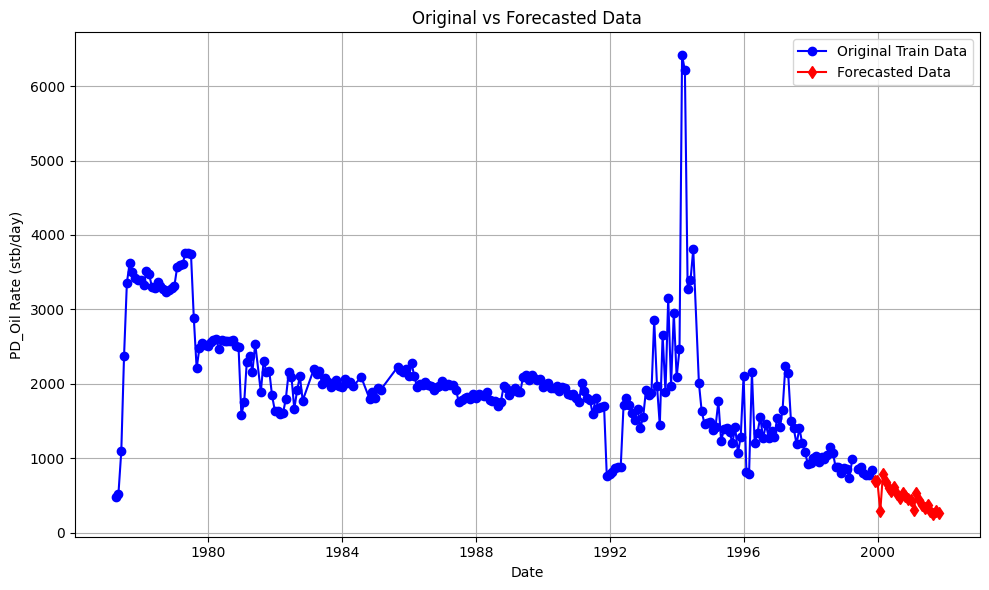

In [48]:
plot_train_infer(df_pdoil, df_pdoil, forecast_entire_data)

In [19]:
forecast_test = best_model.predict(X_test)
forecast_test[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

X_train.shape, y_train.shape, forecast_test[['ds']].shape, forecast_test[['yhat']].shape

((247, 1), (247,), (10, 1), (10, 1))

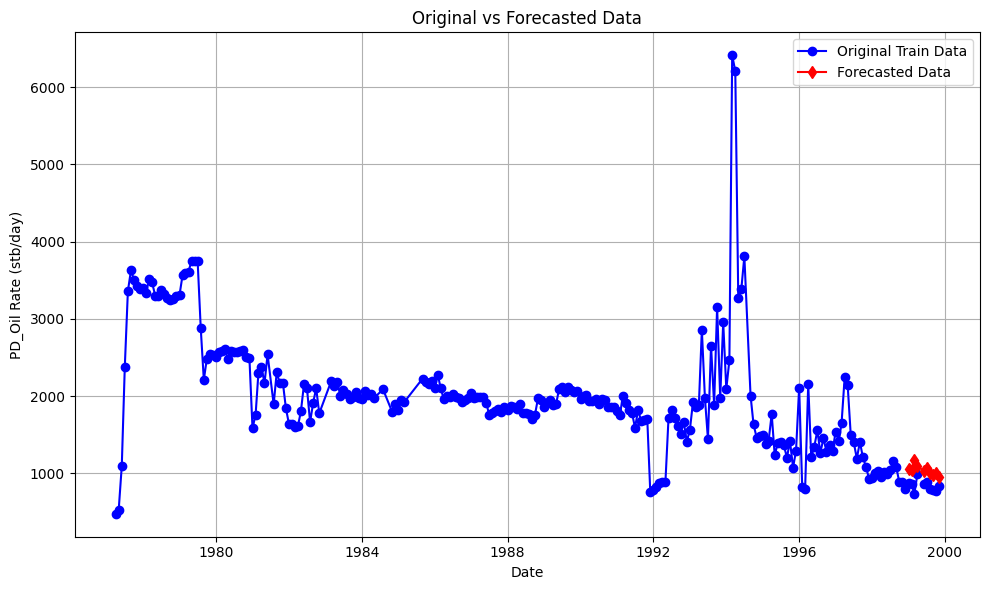

In [119]:
plot_train_infer(df_pdoil, df_pdoil, forecast_test)

In [ ]:
X_test

,ds
247,1999-01-01
248,1999-02-01
249,1999-03-01
250,1999-04-01
252,1999-06-01
253,1999-07-01
254,1999-08-01
255,1999-09-01
256,1999-10-01
257,1999-11-01


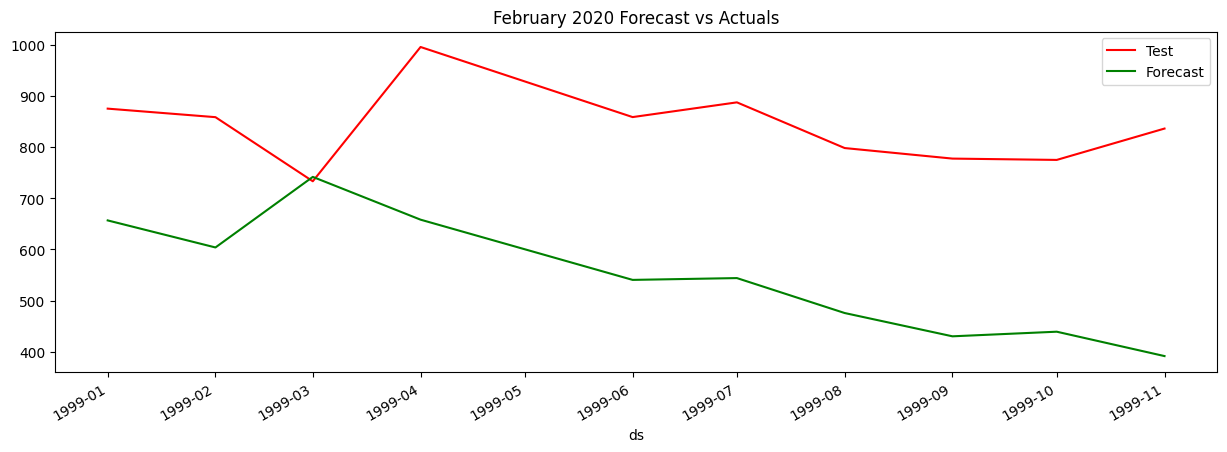

In [123]:
f, ax = plt.subplots(figsize=(14,5))
f.set_figheight(5)
f.set_figwidth(15)
df_test.plot(kind='line', x='ds', y='y', color='red', label='Test', ax=ax)
forecast_test.plot(kind='line', x='ds', y='yhat', color='green',label='Forecast', ax=ax)
plt.title('February 2020 Forecast vs Actuals')
plt.show()

In [36]:
mape = mean_absolute_percentage_error(y_test, forecast_test['yhat'])
print("MAPE",round(mape,4))

MAPE 0.347


In [41]:
df_traintest = pd.concat((df_train, df_test))

In [42]:
forecast_model = Prophet(
    seasonality_mode='multiplicative',
    changepoint_prior_scale=0.4,
    holidays_prior_scale=0.5,
    n_changepoints=500)

forecast_model.fit(df_traintest)

13:24:37 - cmdstanpy - INFO - Chain [1] start processing


13:24:37 - cmdstanpy - INFO - Chain [1] done processing


In [43]:
# Generate future timestamps for forecasting
PERIODS=24
latest_timestamp = X_test['ds'].iloc[-1]
future_timestamps = pd.date_range(start=latest_timestamp, periods=PERIODS, freq='M')  # Your desired future timestamps
forecast_dates = pd.DataFrame(future_timestamps, columns=['ds'])

In [44]:

forecast_entire_data = forecast_model.predict(forecast_dates)
forecast_entire_data[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
19,2001-06-30,370.446069,-248.881154,1031.536452
20,2001-07-31,295.324647,-262.570477,954.593930
21,2001-08-31,254.536886,-406.290226,868.617833
22,2001-09-30,297.745046,-374.349017,938.049703
23,2001-10-31,263.275267,-400.903342,895.847460


In [45]:
future_forcast = forecast_entire_data['yhat']
future_ds = forecast_entire_data['ds']

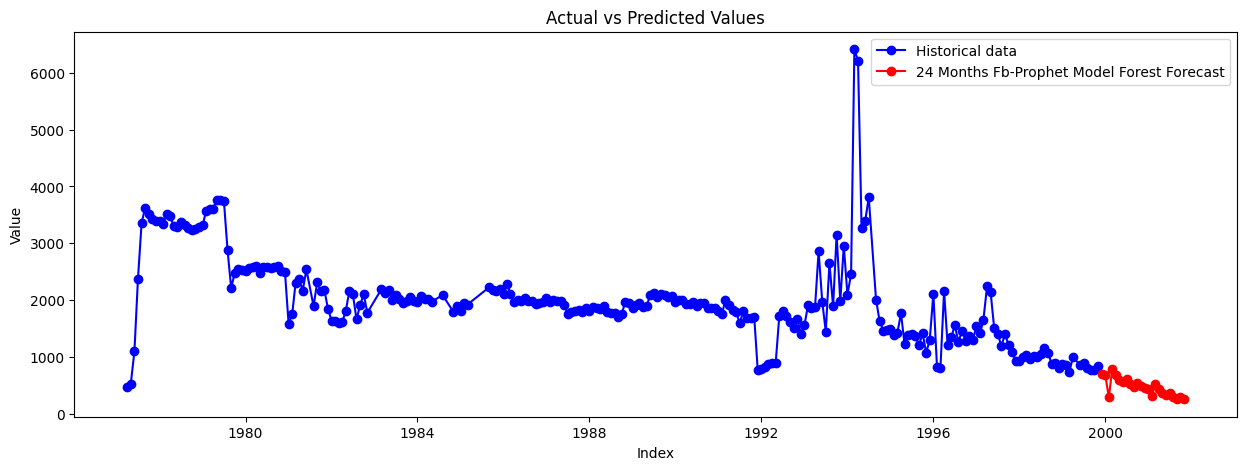

In [46]:
import matplotlib.pyplot as plt

#def plot_forecast(y_test, y_forecast, ds):
    # Plotting actual vs predicted values
plt.figure(figsize=(15, 5))
plt.plot(df_pdoil_clean['ds'], df_pdoil_clean['y'], color='b', label='Historical data', marker='o')
#plt.plot(ds_train_windows.flatten(), xgb_train_forecast, color='r', label='Random Forest Forecast', marker='x')
plt.plot(future_ds, future_forcast, color='r', label=f'{PERIODS} Months Fb-Prophet Model Forest Forecast', marker='o')

plt.xlabel('Index')
plt.ylabel('Value')
plt.title('Actual vs Predicted Values')
plt.legend()
#plt.grid(True)
#plt.tight_layout()
plt.show()